# Comparative study of YOLO vs MediaPipe vs MoveNet

In [14]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

import mediapipe as mp

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed


import numpy as np

# Assume KEYPOINT_DICT is a dictionary that maps YOLO keypoints to Mediapipe keypoints
KEYPOINT_DICT = {
    0: "nose",
    6: "right_shoulder",
    5: "left_shoulder",
    11: "left_hip",
    12: "right_hip",
    14: "right_knee",
    13: "left_knee",
    16: "right_ankle",
    15: "left_ankle",
    7: "left_elbow",
    9: "left_wrist",
    8: "right_elbow",
    10: "right_wrist"
}

# Load the input image.
image_path = 'Yoga poses.v7i.yolov8/valid/images/agacho3_jpeg.rf.094fdb86ff24952f0026b0aba5e2ffbf.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display with matplotlib

# File path to your YOLO txt file
file_path = 'Yoga poses.v7i.yolov8/valid/labels/agacho3_jpeg.rf.094fdb86ff24952f0026b0aba5e2ffbf.txt'

try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.read()
except UnicodeDecodeError:
    print("UTF-8 decoding failed, trying ISO-8859-1 encoding...")
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        data = file.read()

## Define Metrics

In [15]:
def calculate_oks(gt_keypoints, pred_keypoints, bbox_area, indices):
    # Object Keypoint Similarity (OKS) is a metric used to evaluate the accuracy of keypoint predictions

    sigmas = np.array([0.26, 0.25, 0.25, 0.35, 0.35, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62])
    #sigmas = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1 ,0.1 ,0.1, 0.1, 0.1])

    #Filter keypoints
    selected_sigmas = []

    for j in indices:
        selected_sigmas.append(sigmas[j])

    #print("gt_kpts: ", gt_keypoints)

    # Ensure both keypoints lists have exactly 13 keypoints
    gt_keypoints = gt_keypoints[:13]
    pred_keypoints = pred_keypoints[:13]


    y_true = np.array(gt_keypoints).reshape(-1, 2)
    y_pred = np.array(pred_keypoints).reshape(-1, 2)

    #print("ytrue: ", y_true)
    #print("ypred: ", y_pred)

    # Handle cases where there might be fewer keypoints
    if y_true.shape[0] != y_pred.shape[0]:
        raise ValueError(f"Shape mismatch between ground truth and predicted keypoints: {y_true.shape} vs {y_pred.shape}")


    # Calculate Euclidean distance between keypoints
    d2 = (y_true - y_pred)**2 
    # d^2 = (x1 - x2)^2 + (y1 - y2)^2
    d2_sum = d2.sum(axis=1)

    #print(d2_sum)
    

    # Adjust sigmas shape if necessary
    if sigmas.shape[0] != d2.shape[1]:
        sigmas = sigmas[:d2.shape[1]]

    # COCO assigns k = 2σ.
    for i in range(len(selected_sigmas)):
        selected_sigmas[i] = 2 * selected_sigmas[i]

    #print(selected_sigmas)

    denom=[]
    # Denominator in the exponent term. Shape: [M, 1, #kpts]
    for k in range(len(selected_sigmas)):
        denom.append( 2 * (selected_sigmas[k]**2) * bbox_area )
    
    #print( -d2_sum/denom )

    # Calculate OKS
    oks = np.exp(-d2_sum / denom )

    return oks


def calculate_mppe(gt_keypoints, pred_keypoints):
    # Mean Per Part Error (MPPE) is the average error between predicted and ground truth parts detected (pairs of keypoints)

    # Ensure both keypoints lists have exactly 13 keypoints by truncating or padding
    def adjust_keypoints(keypoints, target_len=13):
        # If there are more than 13 keypoints, truncate the list
        if len(keypoints) > target_len:
            keypoints = keypoints[:target_len]
        # If there are fewer than 13, pad with (0,0) to make up the difference
        else:
            while len(keypoints) < target_len:
                keypoints.append([0, 0])  # Padding with [0, 0] for missing keypoints
        return keypoints

    # Adjust the shape of both ground truth and predicted keypoints
    gt_keypoints = adjust_keypoints(gt_keypoints)
    pred_keypoints = adjust_keypoints(pred_keypoints)

    # Handle missing keypoints by replacing them with a placeholder
    def handle_missing_keypoints(keypoints):
        # Use np.array_equal to compare arrays
        return [[0, 0] if np.array_equal(k, [0, 0]) else k for k in keypoints]

    gt_keypoints = handle_missing_keypoints(gt_keypoints)
    pred_keypoints = handle_missing_keypoints(pred_keypoints)

    error_array = []
    
    # Converted limb pairs based on keypoints array
    limb_pairs = [(1, 9), (9, 11), (2, 10), (10, 12), (3, 5), (5, 7), (4, 6), (6, 8)]

    for (i, j) in limb_pairs:
        # Skip the part if either keypoint in the pair is missing
        if np.array_equal(gt_keypoints[i], [0, 0]) or np.array_equal(gt_keypoints[j], [0, 0]):
            continue

        gt_dist = np.linalg.norm(np.array(gt_keypoints[i]) - np.array(gt_keypoints[j]))
        pred_dist = np.linalg.norm(np.array(pred_keypoints[i]) - np.array(pred_keypoints[j]))
        
        # Check if the predicted distance is within a threshold
        error_array.append(abs(gt_dist - pred_dist) / gt_dist)

    # If no valid error was calculated (empty error array), return a fallback value (like 0)
    if len(error_array) == 0:
        return 0
    
    return error_array

## Deploying models and extracting predicted keypoints

### MoveNet

In [16]:
module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
input_size = 192


def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores



# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

#print("Keypoints with scores: ", keypoints_with_scores)


#---------------------------------Predicted Keypoints---------------------------------

predicted_kpts = []   #normalized

coco_indices = [0, 6, 5, 11, 12, 14, 13, 16, 15, 7, 9, 8, 10]   #order of keypoints presented in the dataset, check keypoint dictionary to verify which joint is which

#Filter the keypoints to only include the ones we want
for i in coco_indices:
    predicted_kpts.append(keypoints_with_scores[0][0][i])


# Convert normalized coordinates to image pixel coordinates
pred_kpts = []
for kp in predicted_kpts:
    x = kp[0] * 640
    y = kp[1] * 640
    pred_kpts.append([y, x])


pred_movenet = pred_kpts

### Mediapipe

In [17]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    return results, image_rgb

results, image_rgb = process_image(image_path)

# Get image dimensions
image_height, image_width, _ = image.shape


mediapipe_indices = [0, 12, 11, 23, 24, 26, 25, 28, 27, 13, 15, 14, 16]     #order of keypoints presented in the dataset


# ----------------------------------Predicted keypoints----------------------------------------------

# Extract the 13 keypoints from MediaPipe according to KEYPOINT_DICT
if results.pose_landmarks:
    keypoints = results.pose_landmarks.landmark
    pred_kpts = []
    
    # Loop over selected keypoints in KEYPOINT_DICT
    for i in mediapipe_indices:
        kp = keypoints[i]
        # Normalize keypoints to YOLO format (x and y between 0 and 1)
        x = kp.x * image_width
        y = kp.y * image_height
        pred_kpts.append((x, y))
    
    # Convert keypoints to numpy array for easier manipulation
    pred_kpts = np.array(pred_kpts)
  
    pred_mp = pred_kpts

I0000 00:00:1733262396.468173    5854 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733262396.532932    6857 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.107.02), renderer: NVIDIA GeForce RTX 3070/PCIe/SSE2
W0000 00:00:1733262396.588711    6846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733262396.616662    6854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


### YOLOv8

In [18]:
# Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8m-pose.pt')

# Perform object detection on an image using the model
results = model(image_path)

# Define the indices for the 13 keypoints we need
# Using MediaPipe indices: 
# 0: Nose, 5: Left Shoulder, 6: Right Shoulder, 11: Left Hip, 12: Right Hip, 
# 13: Left Knee, 14: Right Knee, 15: Left Ankle, 16: Right Ankle, 7: Left Elbow, 8: Right Elbow,
# 9: Left Wrist, 10: Right Wrist
selected_indices = [0, 6, 5, 11, 12, 14, 13, 16, 15, 7, 9, 8, 10]       #order of keypoints presented in the dataset


# ----------------------------------Predicted keypoints----------------------------------------------
denormalized_kps = []

# Process results
for r in results:
    keypoints = r.keypoints.xyn.cpu().numpy()  # Normalized keypoints (x, y, conf)
    
    for kp in keypoints[0]:
            x, y = int(kp[0] * 640), int(kp[1] * 640) # denormalize , if needed
            denormalized_kps.append((x,y))

pred_kpts = []

# Filter for the 13 specific keypoints
for i in selected_indices:
    pred_kpts.append(denormalized_kps[i])


pred_yolo = pred_kpts


image 1/1 /home/rtu/Documents/HPE_models/Yoga poses.v7i.yolov8/valid/images/agacho3_jpeg.rf.094fdb86ff24952f0026b0aba5e2ffbf.jpg: 640x640 1 person, 12.8ms
Speed: 0.8ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


## Extracting ground truth keypoints from dataset

In [19]:
#++++++++++++++++++++++++++++++++++++++Ground Truth Keypoints++++++++++++++++++++++++++++++++++++++

normal_gt_kpts = [float(value) for i, value in enumerate(data.split()) if 0 < float(value) <= 1 ]


# Reshape keypoints into pairs of (x, y)
normal_gt_kpts = np.array(normal_gt_kpts).reshape(-1, 2)

# Denormalize keypoints
gt_kpts = np.zeros_like(normal_gt_kpts)
gt_kpts[:, 0] = normal_gt_kpts[:, 0] * 640   # Denormalize x by image width
gt_kpts[:, 1] = normal_gt_kpts[:, 1] * 640  # Denormalize y by image height


#print(gt_kpts[2:])
# print(selected_keypoints) visualization and debugging

gt_kpts = gt_kpts[2:]   # remove the first two keypoints as they are part of bbox *VERY IMPORTANT*

#print("Ground truth keypoints: ", gt_kpts)

## Inference and metrics evaluation for each neural network

### MoveNet

OKS MoveNet:  [    0.99974     0.99985     0.99985      0.9998     0.99962     0.99931     0.99995     0.99973     0.99979     0.99996     0.99999     0.99997     0.99958]
MPPE MoveNet:  [0.06092477468572923, 0.49068879430335, 0.13873892296814702, 0.8901432332806263, 0.4521674155445198, 0.00923711795665556, 0.07570280807404492, 0.01554484510639421]


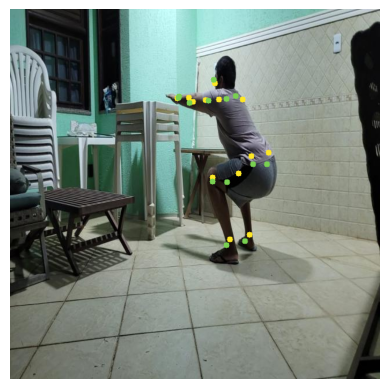

In [20]:
movenet_oks = calculate_oks(gt_kpts, pred_movenet, 640*640*0.53, coco_indices)
movenet_mppe = calculate_mppe(gt_kpts, pred_movenet)


print("OKS MoveNet: ", movenet_oks)
print("MPPE MoveNet: ", movenet_mppe)

image_mp = image_rgb.copy()
image_yolo = image_rgb.copy()

# Draw ground truth keypoints on the image
for x, y in gt_kpts:
    cv2.circle(image, (int(x), int(y)), 5, (253, 231, 36), -1)  # Yellow circles for ground truth keypoints

for x,y in pred_movenet:
    cv2.circle(image, (int(x), int(y)), 5, (121, 209, 81), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image)
plt.axis('off')
plt.show()

### Mediapipe

OKS Mediapipe:  [    0.99939     0.99984     0.99999     0.99962     0.99918     0.99888     0.99992     0.99992     0.99994     0.99986     0.99993     0.99958     0.99993]
MPPE Mediapipe:  [0.02081621669425009, 1.242151909863058, 0.1410056575058177, 0.08891361255546815, 0.43975859647516286, 0.2489110110176563, 0.08042222174873243, 0.029961386861699045]


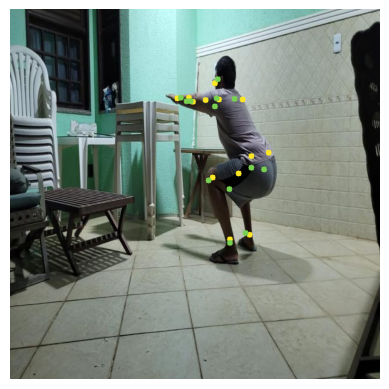

In [21]:
mediapipe_oks = calculate_oks(gt_kpts, pred_mp, 640*640*0.53, coco_indices)
mediapipe_mppe = calculate_mppe(gt_kpts, pred_mp)

print("OKS Mediapipe: ", mediapipe_oks)
print("MPPE Mediapipe: ", mediapipe_mppe)

# Draw ground truth keypoints on the image
for x, y in gt_kpts:
    cv2.circle(image_mp, (int(x), int(y)), 5, (253, 231, 36), -1)  # Yellow circles for ground truth keypoints

for x,y in pred_mp:
    cv2.circle(image_mp, (int(x), int(y)), 5, (121, 209, 81), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image_mp)
plt.axis('off')
plt.show()

### YOLOv8

OKS YOLO:  [    0.29844     0.99995     0.99988     0.99971     0.99931     0.99901     0.99957      0.9996     0.99973     0.99994     0.99999     0.99979     0.99967]
MPPE YOLO:  [0.15829739769562692, 0.006241195719015218, 0.11767143230272407, 0.6098726370910511, 0.4018210683482836, 0.07844229256247771, 0.16860447274904414, 0.07593265803368654]


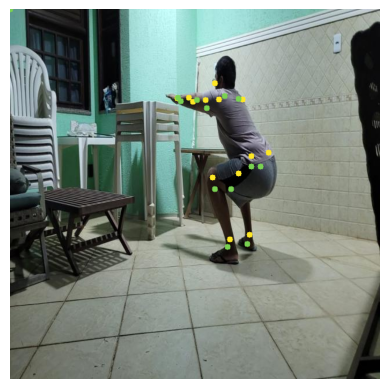

In [22]:
yolo_oks = calculate_oks(gt_kpts, pred_yolo, 640*640*0.53, coco_indices)
yolo_mppe = calculate_mppe(gt_kpts, pred_yolo)

print("OKS YOLO: ", yolo_oks)
print("MPPE YOLO: ", yolo_mppe)

# Draw ground truth keypoints on the image
for x, y in gt_kpts:
    cv2.circle(image_yolo, (int(x), int(y)), 5, (253, 231, 36), -1)  # Yellow circles for ground truth keypoints

for x,y in pred_yolo:
    cv2.circle(image_yolo, (int(x), int(y)), 5, (121, 209, 81), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image_yolo)
plt.axis('off')
plt.show()

## Exporting to spreadsheets

In [23]:
import pandas as pd

# Limb pairs for MPPE with body part labels
limb_pair_names = [
    "left_upper_arm",   # (5, 7)
    "left_lower_arm",   # (7, 9)
    "right_upper_arm",  # (6, 8)
    "right_lower_arm",  # (8, 10)
    "left_upper_leg",   # (11, 13)
    "left_lower_leg",   # (13, 15)
    "right_upper_leg",  # (12, 14)
    "right_lower_leg"   # (14, 16)
]

# OKS Data for Spreadsheet (using keypoint names)
oks_data = {
    "yolo_oks": yolo_oks,
    "mediapipe_oks": mediapipe_oks,
    "movenet_oks": movenet_oks
}

oks_keypoint_names = [f"kp{k}_{v}" for k, v in KEYPOINT_DICT.items()]  # keypoint names like kp0_nose, kp6_right_shoulder, etc.
oks_df = pd.DataFrame(oks_data, index=oks_keypoint_names)

# MPPE Data for Spreadsheet (using body part names for limb pairs)
mppe_data = {
    "yolo_mppe": yolo_mppe,
    "mediapipe_mppe": mediapipe_mppe,
    "movenet_mppe": movenet_mppe
}

mppe_df = pd.DataFrame(mppe_data, index=limb_pair_names)

# Save both to separate Excel files
oks_df.to_excel("OKS_results.xlsx", index=True)
mppe_df.to_excel("MPPE_results.xlsx", index=True)

print("OKS results saved to OKS_results.xlsx")
print("MPPE results saved to MPPE_results.xlsx")

OKS results saved to OKS_results.xlsx
MPPE results saved to MPPE_results.xlsx
